In [31]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

############## part 1 ##############
# Extract data from the database

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

salary_query = "SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries GROUP BY teamID,yearID ORDER BY teamID"

team_salaries = pd.read_sql(salary_query, conn)

win_rate_query = "SELECT teamID, yearID,W as total_wins, sum(W)+sum(L) as total_games, 100*CAST(sum(W) AS float)/(sum(W)+sum(L)) as 'win_rate%', franchID FROM teams GROUP BY teamID,yearID ORDER BY teamID"
team_win_rate = pd.read_sql(win_rate_query, conn)

# inner join these two tables to get rid of the missing data. (ignore missing data)
relationship=team_salaries.merge(team_win_rate, how = "inner", left_on = ["teamID","yearID"], right_on = ["teamID","yearID"])
relationship


,teamID,yearID,total_payroll,total_wins,total_games,win_rate%,franchID
0,ANA,1997,31135472.0,84,162,51.851852,ANA
1,ANA,1998,41281000.0,85,162,52.469136,ANA
2,ANA,1999,55388166.0,70,162,43.209877,ANA
3,ANA,2000,51464167.0,82,162,50.617284,ANA
4,ANA,2001,47535167.0,75,162,46.296296,ANA
...,...,...,...,...,...,...,...
853,WAS,2010,61400000.0,69,162,42.592593,WSN
854,WAS,2011,63856928.0,80,161,49.689441,WSN
855,WAS,2012,80855143.0,98,162,60.493827,WSN
856,WAS,2013,113703270.0,86,162,53.086420,WSN


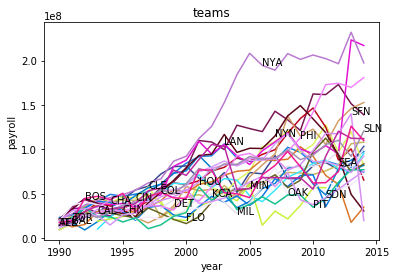

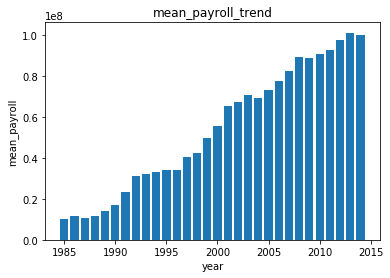

In [32]:
##################### part 2 ###################
result = relationship
result.sort_values("yearID", ascending=True)
temp_result = result[result['yearID'] >= 1990] 
temp_result = temp_result[temp_result['yearID'] <= 2014]
teams = temp_result['teamID'].drop_duplicates()
temp_result = temp_result[['yearID', 'teamID', 'total_payroll']]
temp_result = temp_result.set_index('teamID')
year = 1990
for t in teams:
    temp1 = temp_result.loc[lambda temp_result: temp_result.yearID == year, :]
    if t in temp1.index:
        num = temp1.loc[t,'total_payroll']
        plt.annotate(t, xy = (year, num))
        plt.plot(temp_result.loc[t,'yearID'], temp_result.loc[t,'total_payroll'],color=np.random.rand(3,))
        if (year < 2014):
            year+=1
        else:
            year = 1990

plt.title('teams')
plt.xlabel("year")
plt.ylabel("payroll")
plt.show()
# There is a trend for total payrolls to increase over time, since the payroll of almost each team increase over time.
# So the central tendency of the mean payroll might be increasing over time.
# this graph show the relationship betweem the mean_payroll of all the teams and  years in period (1985-2014)
mean_payroll_trend=(relationship[['yearID','total_payroll']].groupby('yearID')).mean()
plt.bar(mean_payroll_trend.index,mean_payroll_trend['total_payroll'])
plt.xlabel("year")
plt.ylabel("mean_payroll")
plt.title("mean_payroll_trend")
plt.show()
# the mean payroll increased over time form 1985 to 2014.

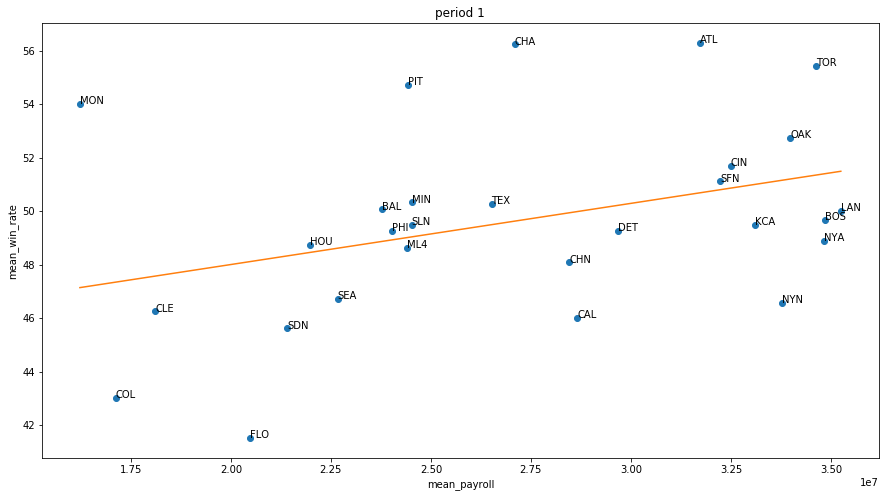

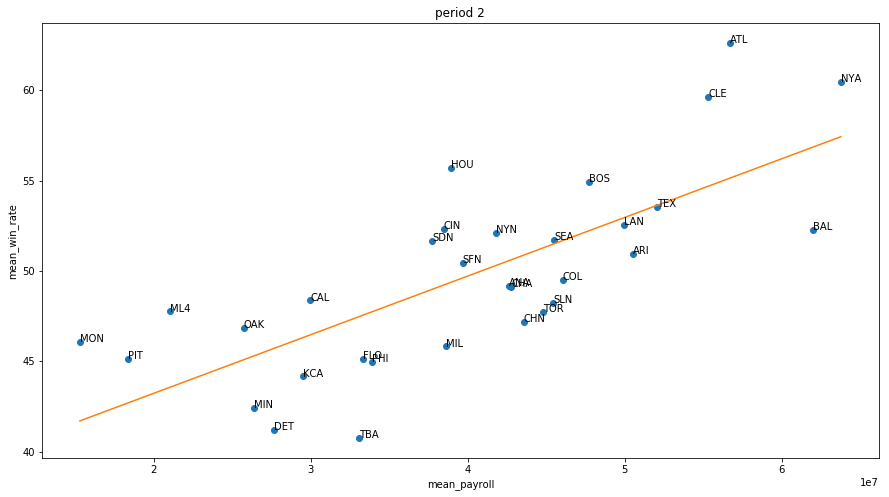

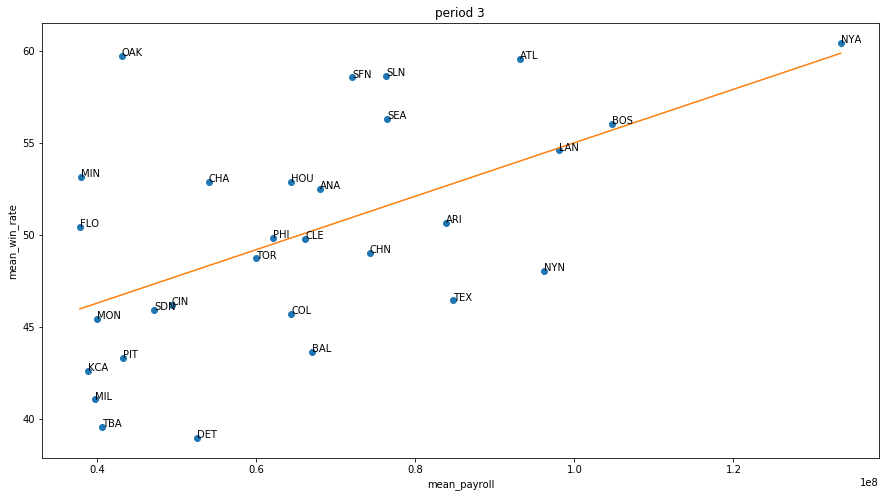

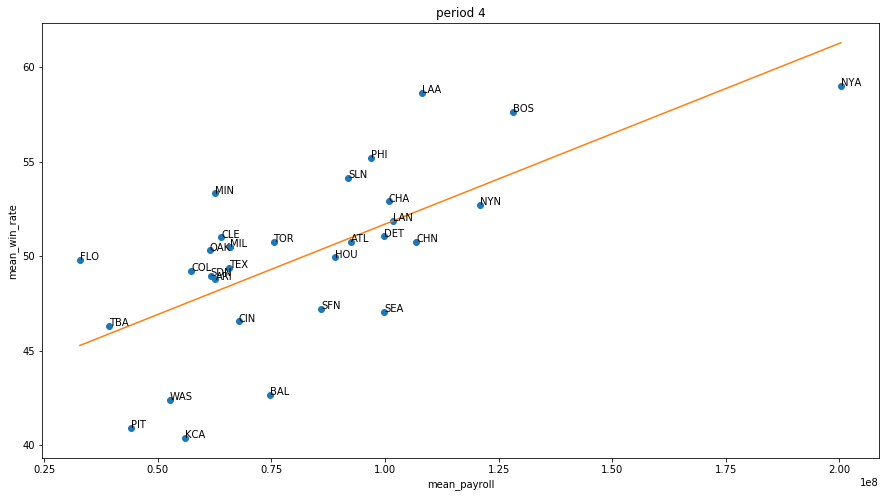

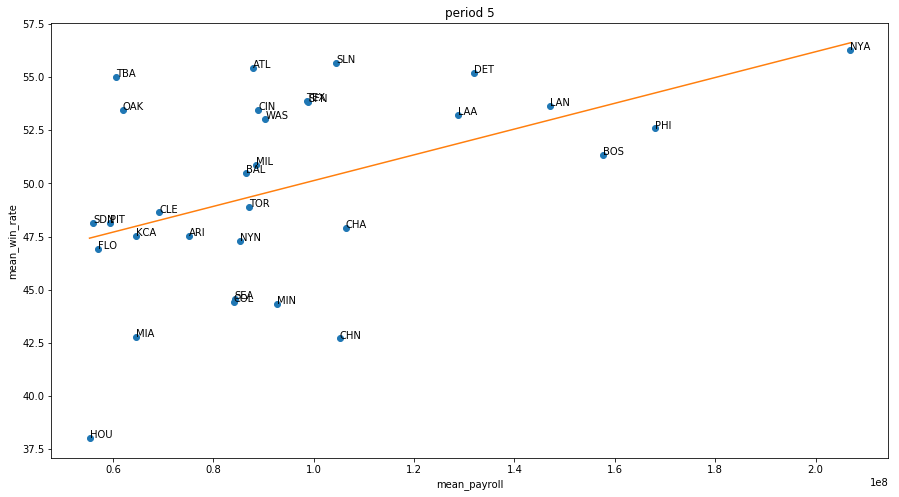

"\n - The team payrolls is increasing accross these periods.\n - According to the interpolation line, basically, if payroll is larger, the win_rate is higher.\n - The team NYA is always at the upper-right corner(except period 1), so basically, \n   this team use the strategy that paying more and gain a higher win_rate.\n - ATL did pretty good on using money efficiently.\n - OAK is always locate at the left half of the graph (except period_1), which means it spent less money,\n   But, it always locate above the interpolation line with large scale. Especially in period_3,\n   OAK's payroll was one of the least, but its win_rate is one of the highest, which means OKA's\n   spending efficiency at that time period is very high!!!\n"

In [33]:
########### Correlation between payroll and winning percentage ##########

temp_df=pd.DataFrame({'yearID':range(1990,2015)})
temp_relation=relationship[['yearID','teamID','total_payroll','total_wins','total_games']]
temp_table=temp_df.merge(temp_relation, how = "left", left_on = ['yearID'], right_on = ['yearID'])

bins = [1990,1995,2000,2005,2010,2015]
group_names=['period 1','period 2','period 3','period 4','period 5']
temp_table['categories'] = pd.cut(temp_table['yearID'],bins,right=False, labels=group_names)

def solve(period):
    
    win_rate_table=temp_table.groupby(['categories']).get_group(period)\
                                    .drop('total_payroll',1).drop('yearID',1).groupby(['teamID']).sum().reset_index()
    win_rate_table['period_win_rate%'] = 100*win_rate_table['total_wins'] / win_rate_table['total_games']
    win_rate_table=win_rate_table.drop('total_wins',1).drop('total_games',1)

    mean_payroll_table=temp_table.groupby(['categories']).get_group(period)\
                                    .drop('total_wins',1).drop('yearID',1).drop('total_games',1).groupby(['teamID']).mean().reset_index()
    mean_payroll_table.columns=['teamID', 'period_mean_payroll']
        
    final_table=mean_payroll_table.merge(win_rate_table)
    
    x_data=final_table['period_mean_payroll'].values
    y_data=final_table['period_win_rate%'].values
    z=np.polyfit(x=x_data,y=y_data,deg=1)
    f=np.poly1d(z)
    x_new = np.linspace(x_data.min(), x_data.max(), 100)
    y_new = f(x_new)
    plt.figure(figsize=(15,8))
    plt.plot(x_data, y_data,'o',x_new,y_new)
    
    for i, txt in enumerate(final_table['teamID']):
        plt.annotate(txt, (x_data[i],y_data[i]),size=10)
    
    plt.xlabel("mean_payroll")
    plt.ylabel("mean_win_rate")
    plt.title(period)
    plt.show()
    pass

for period in group_names:
    solve(period)
# Plot 5 graphs, for each period : x-axis --> mean_payroll  and y-axis --> win_rate

'''
 - The team payrolls is increasing accross these periods.
 - According to the interpolation line, basically, if payroll is larger, the win_rate is higher.
 - The team NYA is always at the upper-right corner(except period 1), so basically, 
   this team use the strategy that paying more and gain a higher win_rate.
 - ATL did pretty good on using money efficiently.
 - OAK is always locate at the left half of the graph (except period_1), which means it spent less money,
   But, it always locate above the interpolation line with large scale. Especially in period_3,
   OAK's payroll was one of the least, but its win_rate is one of the highest, which means OKA's
   spending efficiency at that time period is very high!!!
'''


In [34]:
################## part 3 ##################
mean_payroll = (relationship[['yearID','total_payroll']].groupby('yearID')).mean()
std = (relationship[['yearID','total_payroll']].groupby('yearID')).std()

mean_payroll.columns = ['mean_payroll']
std.columns = ['std']
new_table = temp_table.drop('total_wins',1).copy()

## changing the column name from 'total_games' to 'std_payroll' and assign new datas to this column by using for loop.
new_table.columns = ['yearID', 'teamID', 'total_payroll', 'std_payroll', 'categories']

stand = []
for index, row in new_table.iterrows():
    stand.append((row['total_payroll'] - mean_payroll['mean_payroll'][row["yearID"]]) / std['std'][row["yearID"]])

new_table['std_payroll'] = stand
new_table = temp_df.merge(new_table, how = "left", left_on = ['yearID'], right_on = ['yearID'])


new_table

,yearID,teamID,total_payroll,std_payroll,categories
0,1990,ATL,14555501.0,-0.667275,period 1
1,1990,BAL,9680084.0,-1.959861,period 1
2,1990,BOS,20558333.0,0.924213,period 1
3,1990,CAL,21720000.0,1.232198,period 1
4,1990,CHA,9491500.0,-2.009859,period 1
...,...,...,...,...,...
723,2014,SLN,120693000.0,0.457126,period 5
724,2014,TBA,72689100.0,-0.593171,period 5
725,2014,TEX,112255059.0,0.272509,period 5
726,2014,TOR,109920100.0,0.221422,period 5


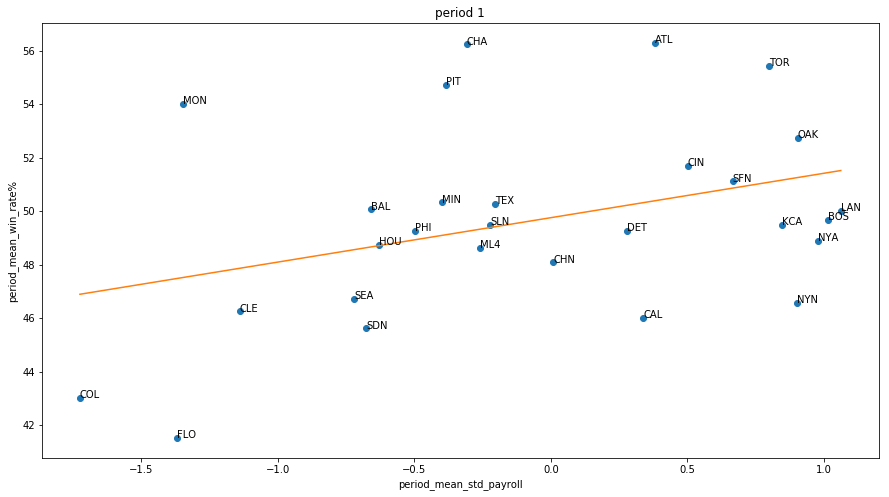

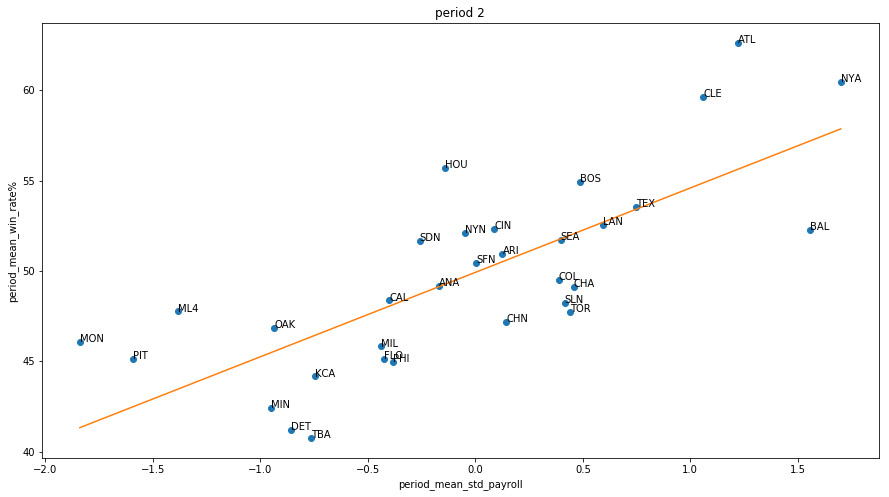

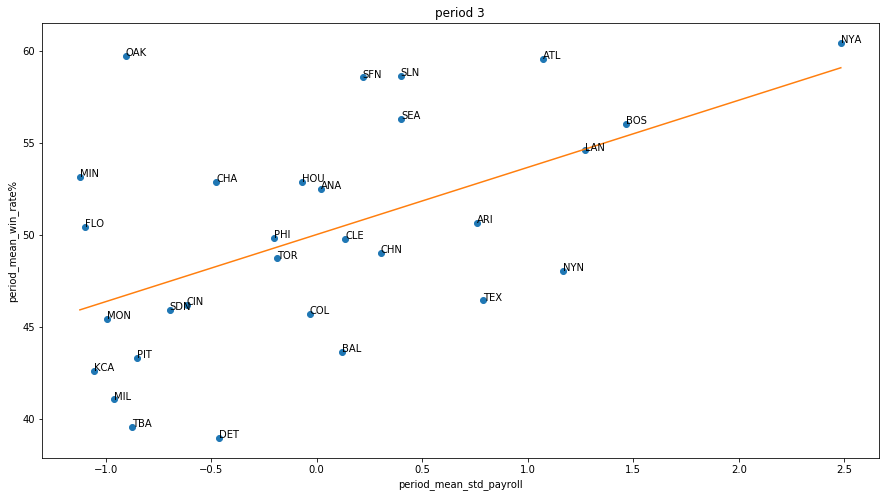

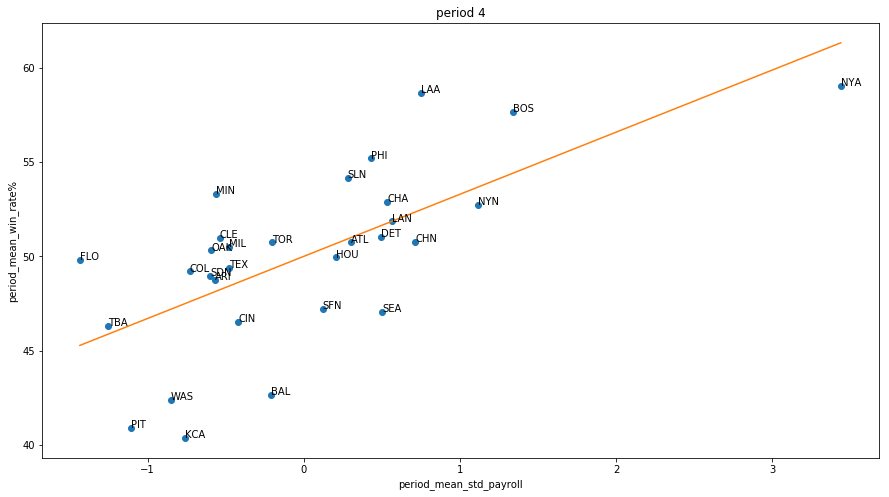

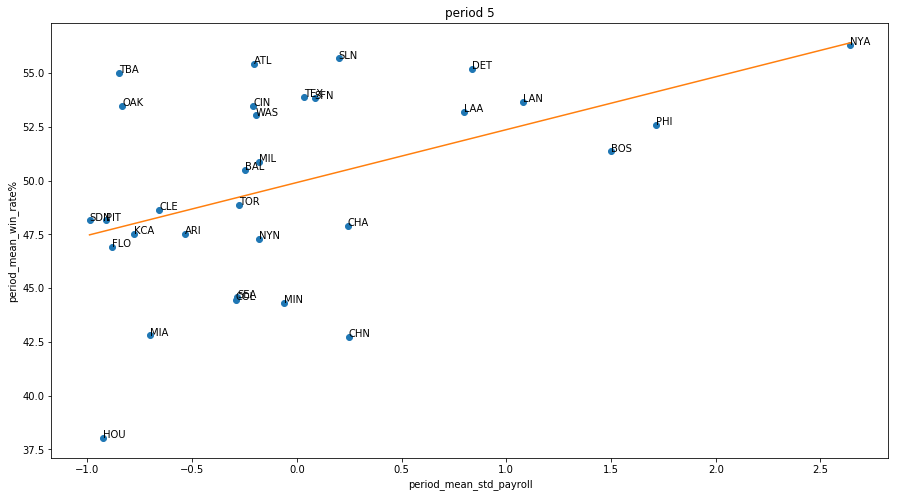

In [35]:
def solve2(period):
    std_payroll_table = new_table.groupby(['categories']).get_group(period)\
                                   .drop('total_payroll',1).drop('yearID',1).groupby(['teamID']).mean().reset_index()
    std_payroll_table.columns=['teamID','period_std_payroll']
    
    win_rate_table=temp_table.groupby(['categories']).get_group(period)\
                                    .drop('total_payroll',1).drop('yearID',1).groupby(['teamID']).sum().reset_index()
    win_rate_table['period_win_rate%'] = 100*win_rate_table['total_wins'] / win_rate_table['total_games']
    win_rate_table=win_rate_table.drop('total_wins',1).drop('total_games',1)
        
    final_table = win_rate_table.merge(std_payroll_table)
    x_data=final_table['period_std_payroll'].values
    y_data=final_table['period_win_rate%'].values
    z=np.polyfit(x=x_data,y=y_data,deg=1)
    f=np.poly1d(z)
    x_new = np.linspace(x_data.min(), x_data.max(), 100)
    y_new = f(x_new)
    plt.figure(figsize=(15,8))
    plt.plot(x_data, y_data,'o',x_new,y_new)
    
    for i, txt in enumerate(final_table['teamID']):
        plt.annotate(txt, (x_data[i],y_data[i]),size=10)
    
    plt.xlabel("period_mean_std_payroll")
    plt.ylabel("period_mean_win_rate%")
    plt.title(period)
    plt.show()

for period in group_names:
    solve2(period)

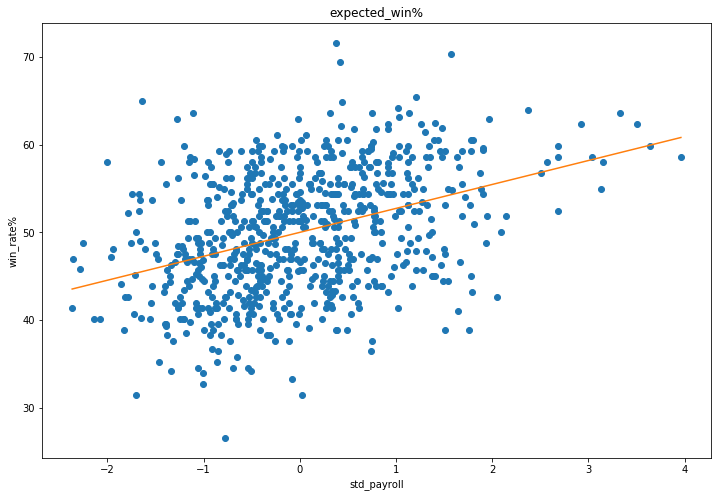

,teamID,yearID,win_rate%,std_payroll,expected_win%
0,ATL,1990,40.123457,-0.667275,48.331811
1,BAL,1990,47.204969,-1.959861,45.100348
2,BOS,1990,54.320988,0.924213,52.310533
3,CAL,1990,49.382716,1.232198,53.080495
4,CHA,1990,58.024691,-2.009859,44.975353
...,...,...,...,...,...
723,SLN,2014,55.555556,0.457126,51.142816
724,TBA,2014,47.530864,-0.593171,48.517072
725,TEX,2014,41.358025,0.272509,50.681273
726,TOR,2014,51.234568,0.221422,50.553554


In [45]:
temp_relation=relationship[['yearID','teamID','total_payroll','win_rate%']]
temp_table=temp_df.merge(temp_relation, how = "left", left_on = ['yearID'], right_on = ['yearID'])
expected_win_pct = temp_table[['teamID','yearID','win_rate%']].copy()
expected_win_pct['std_payroll'] = new_table['std_payroll']

x_data=expected_win_pct['std_payroll'].values
y_data=expected_win_pct['win_rate%'].values
z=np.polyfit(x=x_data,y=y_data,deg=1)
f=np.poly1d(z)
x_new = np.linspace(x_data.min(), x_data.max(), 100)
y_new = f(x_new)
plt.figure(figsize=(12,8))
plt.plot(x_data, y_data,'o',x_new,y_new)

plt.xlabel("std_payroll")
plt.ylabel("win_rate%")
plt.title("expected_win%")
plt.show()

expected_win_pct['expected_win%']  = expected_win_pct['std_payroll']*2.5+50

expected_win_pct

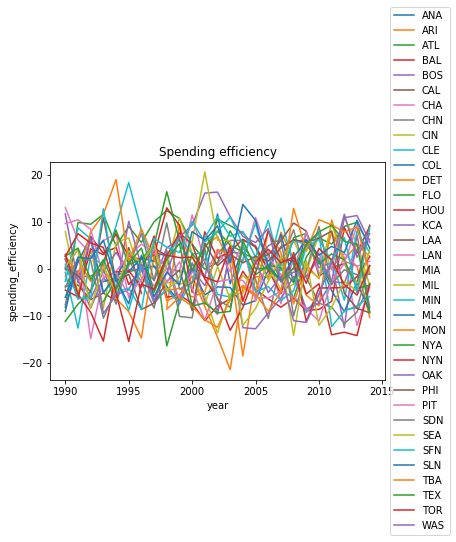

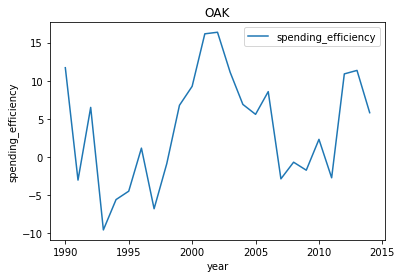

In [43]:
temp = temp_table[['yearID', 'teamID', 'win_rate%']].copy()
temp['expected_win%'] = expected_win_pct['expected_win%']
temp['spending_efficiency'] = temp['win_rate%'] - temp['expected_win%']
lst = temp['teamID'].unique()
#take the recommanded five teams' data
spending_efficiency = temp.loc[temp['teamID'].isin(lst)].sort_values(['teamID', 'yearID'], ascending = [True, True])
OAK = temp.loc[temp['teamID'].isin(['OAK'])].sort_values(['teamID', 'yearID'], ascending = [True, True])

fig, ax = plt.subplots()
labels = []

#construct line grpah for each team
for key, grp in spending_efficiency.groupby(['teamID']):
    ax = grp.plot(ax=ax, kind='line', x='yearID', y='spending_efficiency')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

#show all team's graph with plots
#plt.plot(spending_efficiency['yearID'].values, spending_efficiency['spending_efficiency'].values ,'.', c = 'black')
plt.xlabel("year")
plt.ylabel("spending_efficiency")
plt.title("Spending efficiency")
plt.show()

fig, ax = plt.subplots()
for key, grp in OAK.groupby(['teamID']):
    ax = grp.plot(ax=ax, kind='line', x='yearID', y='spending_efficiency')
    
plt.xlabel("year")
plt.ylabel("spending_efficiency")
plt.title("OAK")
plt.show()